# Condições socioeconômicas dos bairros de Vila Velha com mapa de calor

### Projeto desenvolvido para determinar as condições socioeconômicas dos bairros de Vila Velha, de acordo com o valor de venda/quartos/m² das casasà venda pelo site da OLX. Devemos considerar este projeto como um estudo, pois seus dados podem não estar completamente fiéis à realidade.

In [1]:
""" 
Importando algumas das bibliotecas necessarias e editando as configurações de exposição de dados do pandas
(essa última serve somente para uma pré observação mais extensa dos dados) 
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
import re
from urllib.request import Request, urlopen

pd.set_option('display.max_rows', 350)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)

In [2]:
"""
Os dados dos quais precisamos estão espalhados em diversas páginas do site da olx. O link para todas as páginas 
é o mesmo, com excessão do valor final que define o número da página. Utilizaremos WHILE para capturar um número
determinado de páginas, salvando-as como um grande conjunto de strings concatenadas na variável webpage.
"""

link = 'https://es.olx.com.br/norte-do-espirito-santo/vila-velha/imoveis/venda/casas?o='

webpage = ""

def takealllinks(link, web):
    numb = 0
    while numb <= 30:
        numb = numb+1
        numb = str(numb)
        requi = Request(link+numb, headers={'User-Agent': 'Mozilla/5.0'})
        webr = urlopen(requi).read().decode('utf-8')
        web = web+webr
        numb = int(numb)
    return web
    
webpage = takealllinks(link, webpage)
#webpage

In [3]:
"""
Aqui começamos a tratar os dados, removendo alguns termos como por exemplo as vagas e os valores de condomínios, 
que não são dados na maioria dos anuncios.
"""

wp = webpage
wp = wp.replace(" | 3 vagas", "")
wp = wp.replace(" | 2 vagas", "")
wp = wp.replace(" | 1 vaga", "")
wp = wp.replace(" | 4 vagas", "")
wp = wp.replace(" | 5 vagas", "")
wp = wp.replace(" | 5 ou mais vaga", "")
wp = wp.replace("ou mais quarto", "quartos")
wp = wp.replace(" | Condomínio: R$ 0", "")
wp = wp.replace(" | Condomínio: R$ 80.000", "")
wp = wp.replace(" | Condomínio: R$ 1.200", "")
wp = wp.replace(" | ", " ")
wp = wp.replace(" quartos", "")
wp = wp.replace(" quarto", "")
wp = wp.replace("m²", "")
wp = wp.replace("R$ ", "")
wp = wp.replace(".", "")

In [4]:
"""
Agora com o uso de expressões regulares buscamos as fatias que representam a quantidade de quartos e àrea 
das casas anunciadas. 
"""

geral = re.findall(r'</h2><p class="jm5s8b-0 jDoirm">(.+?)</p>', wp)
geral = DataFrame(geral, columns=['geral'])
geral.tail(15)

,geral
1203,3 300 Condomínio: 1
1204,5 280
1205,4 391
1206,3
1207,3 199
1208,2 497
1209,3 410
1210,5 0
1211,2
1212,3 200


In [5]:
"""
Ainda com expressões regulares buscamos seus valores.
"""

valor=re.findall(r'<div class="fnmrjs-15 clbSMi"><p class="fnmrjs-16 jqSHIm">(.+?)</p>', wp) 
valor = DataFrame(valor, columns=['valor'])
valor.tail()

,valor
1232,330000
1233,110000
1234,850000
1235,750000
1236,420000


In [6]:
"""
E por fim seus bairros de localização.
"""

bairro = re.findall(r'<p class="fnmrjs-13 hdwqVC">(.+?)</p><p class="fnmrjs-14 iIprpQ">', wp)
bairro = DataFrame(bairro, columns=['bairro'])
bairro.tail()

,bairro
1232,"Vila Velha, Novo México"
1233,"Vila Velha, Glória"
1234,"Vila Velha, Novo México"
1235,"Vila Velha, Vila Nova"
1236,"Vila Velha, Jockey de Itaparica"


In [7]:
"""
O que faremos agora é concatenar todas as informações geradas antes em um unico dataset de 3 colunas e tratar seus dados,
removendo algumas colunas especificas com formatação estranha, valores nulos e faltantes e alguns valores sem muito nexo.
Basicamente, filtraremos os dados aparentemente mais fiéis à realidade.
"""

dftotal = pd.concat([geral, valor, bairro], axis=1)
dftotal = dftotal.drop([11,15,17,18,19,23,24,28,34,36,37])
dftotal[['quartos', 'metros']] = dftotal['geral'].str.split(' ', n=1, expand=True)
dftotal.reset_index(inplace=True)
dftotal = dftotal[['quartos','metros','valor','bairro']]
dftotal.dropna()
dftotal = dftotal.replace(to_replace ='Condomínio: [0-9][0-9]\.[0-9][0-9][0-9]', value = '', regex = True)
dftotal = dftotal.replace(to_replace ='Condomínio: [0-9]\.[0-9][0-9][0-9]', value = '', regex = True)
dftotal = dftotal.replace(to_replace ='Condomínio: [0-9][0-9][0-9]', value = '', regex = True)
dftotal = dftotal.replace(to_replace ='Condomínio: [0-9][0-9]', value = '', regex = True)
dftotal = dftotal.replace(to_replace ='Condomínio: [0-9]', value = '', regex = True)
dftotal.fillna(value=pd.np.nan, inplace=True)
dftotal.dropna(inplace=True)
dftotal = dftotal[~dftotal.valor.str.contains("<")]
dftotal = dftotal[~dftotal.valor.str.contains(" ")]
dftotal = dftotal[~dftotal.quartos.str.contains(" ")]
dftotal = dftotal[~dftotal.quartos.str.contains("Condomínio")]
dftotal = dftotal[~dftotal.metros.str.contains(" ")]
dftotal = dftotal[dftotal.bairro.str.contains("Vila Velha")]
dftotal = dftotal.drop(dftotal[dftotal.metros == 'vaga'].index) 
dftotal.reset_index(inplace=True)
dftotal = dftotal[['quartos','metros','valor','bairro']]
dftotal = dftotal.drop([101])
dftotal[["quartos","valor", "metros"]] = dftotal[["quartos","valor", "metros"]].apply(pd.to_numeric)
dftotal = dftotal.drop(dftotal[dftotal.metros <= 40].index) 
dftotal = dftotal.drop(dftotal[dftotal.metros >= 10000].index)  

"""
Caso algumas colunas apresentem erro de formatação, podemos observa-las individualmente com o iloc e editar as 
configurações do filtro acima.
"""
#dftotal.iloc[ 142 , : ]
dftotal.head()

C:\Users\Mathe\anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


,quartos,metros,valor,bairro
0,2,300.0,100000,"Vila Velha, Praia da Costa"
1,3,500.0,750000,"Vila Velha, Praia das Gaivotas"
2,3,285.0,580000,"Vila Velha, Araçás"
3,4,190.0,600000,"Vila Velha, Ponta da Fruta"
4,3,180.0,600000,"Vila Velha, Araçás"


In [8]:
"""
O que fazemos agora é criar uma nova variavel, que relacione um valor comum às casas, afim de comparar esse 
valor bairro a bairro futuramente. Aqui, este valor será determinado com relação ao preço da casa, seu
número de quartos e de metros quadrados. Abaixo obteremos o valor "relativo" de cada casa somados para seu 
determinado bairro.
"""

dftotal['vrelativo'] = (dftotal['valor']/dftotal['metros'])/dftotal['quartos']
dftotal.sort_values(by ='bairro', ascending=False, inplace=True)
dftotal2 = dftotal.groupby(['bairro'])['vrelativo'].agg('sum')
dftotal2 = DataFrame(dftotal2)
dftotal2.reset_index(inplace=True)
dfvr = dftotal2['vrelativo']
dfvr.head(15)

0      3102.258497
1       920.671391
2     20696.217593
3       960.952381
4      8479.940965
5     75584.829676
6     30832.264902
7     13655.050505
8      3911.421278
9       812.342880
10      916.666667
11     5153.074866
12      160.317460
13      975.181024
14    39916.655328
Name: vrelativo, dtype: float64

In [9]:
"""
Com o valor relativo de cada casa em mãos, dividiremos todos esses valores somados pela quantidade de casas por bairro,
obtendo agora o valor por casa médio de cada bairro.
"""

dfcounts = dftotal.bairro.value_counts()
dfcounts = DataFrame(dfcounts)
dfcounts.reset_index(inplace=True)
dfcounts.rename(columns  = {"bairro":"ncasas" , 'index':"bairro"}, inplace = True)
dfcounts.sort_values(by ='bairro', ascending=True, inplace=True)
dfcounts.reset_index(inplace=True)
dfcounts = pd.concat([dfcounts, dfvr], axis=1)
dfcounts = dfcounts[['bairro', 'ncasas', 'vrelativo']]
dfcounts['valorm'] = dfcounts['vrelativo']/dfcounts['ncasas']
dfcounts.tail(10)

,bairro,ncasas,vrelativo,valorm
70,"Vila Velha, São Conrado",5,2550.170146,510.034029
71,"Vila Velha, São Torquato",4,603.422619,150.855655
72,"Vila Velha, Tapuera da Barra",3,3112.361111,1037.453704
73,"Vila Velha, Terra Vermelha",5,3149.197384,629.839477
74,"Vila Velha, Ulisses Guimarães",8,1985.155037,248.144380
75,"Vila Velha, Vale Encantado",14,15776.271713,1126.876551
76,"Vila Velha, Vila Garrido",7,3369.107712,481.301102
77,"Vila Velha, Vila Nova",11,21051.629466,1913.784497
78,"Vila Velha, Vinte e Três de Maio",2,425.727921,212.863960
79,"Vila Velha, Zumbí dos Palmares",1,135.416667,135.416667


In [10]:
"""
Me vi na necessidade de aplicar uma transformação da coluna bairros para lista, pois o geopy não aceitou o formato de série.
"""

dflist = dfcounts.bairro.tolist()

In [11]:
"""
Com o geopy encontramos as latitudes e longitudes de cada bairro e as as salvaremos em duas listas, lat e long, adicionando 
uma string "a" para os bairros dos quais as latitudes e/ou longitudes não puderam ser obtidas por algum motivo. Essa adição
servirá para um futuro tratamento dos dados.
"""

from geopy.geocoders import Nominatim
lat=[]
long=[]
geolocator = Nominatim(user_agent="Matheus Alved Tostes")
for i in dflist:
    try:
        location = geolocator.geocode(i, timeout=None)
        lat.append(location.latitude)
        long.append(location.longitude)
    except:
        lat.append('a')
        long.append('a')

In [12]:
"""
Agora transformamos as listas criadas em series e às concatenamos ao dataframe que ja possuímos, tratando as latitudes e 
longitudes que não puderam ser encontradas.
"""

dflat = pd.Series(lat)
dflong = pd.Series(long)
dfcoord = pd.concat([dflat, dflong], axis=1)
dfcoord.columns = ['lat','long']
dfnovo = pd.concat([dfcounts, dfcoord],axis=1)
dfnovo = dfnovo.drop(dfnovo[dfnovo.lat == 'a'].index) 
df11 = dfnovo[['bairro','lat','long','valorm']]
df11 = df11.drop(df11[df11.bairro == 'Vila Velha, Darly Santos'].index) 
dfresultado = df11.sort_values(by ='bairro', ascending=True)
dfresultado.head()

,bairro,lat,long,valorm
0,"Vila Velha, Alecrim",-20.3466,-40.3419,620.451699
1,"Vila Velha, Alvorada",-20.3452,-40.3484,131.524484
2,"Vila Velha, Araçás",-20.3854,-40.3254,1149.789866
3,"Vila Velha, Argolas",-20.3357,-40.3362,480.476190
4,"Vila Velha, Aribiri",-20.3415,-40.3167,498.820057


In [13]:
"""
Devo adimitir que o mapa de calor não aceitou os valores relativos muito bem, alguns bairros possuiam valor relativo muito
maiores que outros, fazendo com que as bolhas do grafico ficassem quase invisiveis em muitos casos. Forcei então uma 
normalização dos dados. Tirando a raíz da coluna valorm, eu crio uma nova coluna valormr onde a diferença entre os valores
relativos entre os bairros se torna muito menor, mantendo clara a diferença de valor entre os bairros sem perder informação
dos bairros mais carentes.
"""

dfresultado['valormr'] = dfresultado['valorm']**(1/30)
dfresultado.sort_values(by ='valormr', ascending=False, inplace=True)
dfresultado.head(100)

,bairro,lat,long,valorm,valormr
5,"Vila Velha, Ataíde",-20.3436,-40.3239,4446.166452,1.323121
47,"Vila Velha, Nova Ponta da Fruta",-20.5252,-40.3726,3439.588240,1.311848
53,"Vila Velha, Praia da Costa",-20.335,-40.2824,3042.822562,1.306499
43,"Vila Velha, Morro da Lagoa",-20.4969,-40.365,2803.380580,1.302935
31,"Vila Velha, Itapuã",-20.3523,-40.2897,2433.385757,1.296802
7,"Vila Velha, Barra do Jucu",-20.4285,-40.3252,2275.841751,1.293912
49,"Vila Velha, Olaria",-20.3331,-40.3,2172.619048,1.291912
30,"Vila Velha, Interlagos",-20.4804,-40.3507,1949.080836,1.287244
77,"Vila Velha, Vila Nova",-20.3644,-40.3146,1913.784497,1.286460
65,"Vila Velha, Santa Paula I",-20.4156,-40.3331,1902.403224,1.286205


In [17]:
"""
Como o gmaps atualmente cobra pelo uso de seu mapa de calor, busquei o plotly como alternativa, o que me rendeu esse 
mapa bem bonito :D
"""

import plotly.express as px
fig = px.density_mapbox(dfresultado, lat='lat', lon='long', z='valormr', radius=60,
                        center=dict(lat=0, lon=180), zoom=10, hover_name="bairro",
                        mapbox_style="stamen-terrain", opacity=0.6)
fig.update_layout(mapbox_style="open-street-map", mapbox_center_lon=-40.35, mapbox_center_lat=-20.41)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

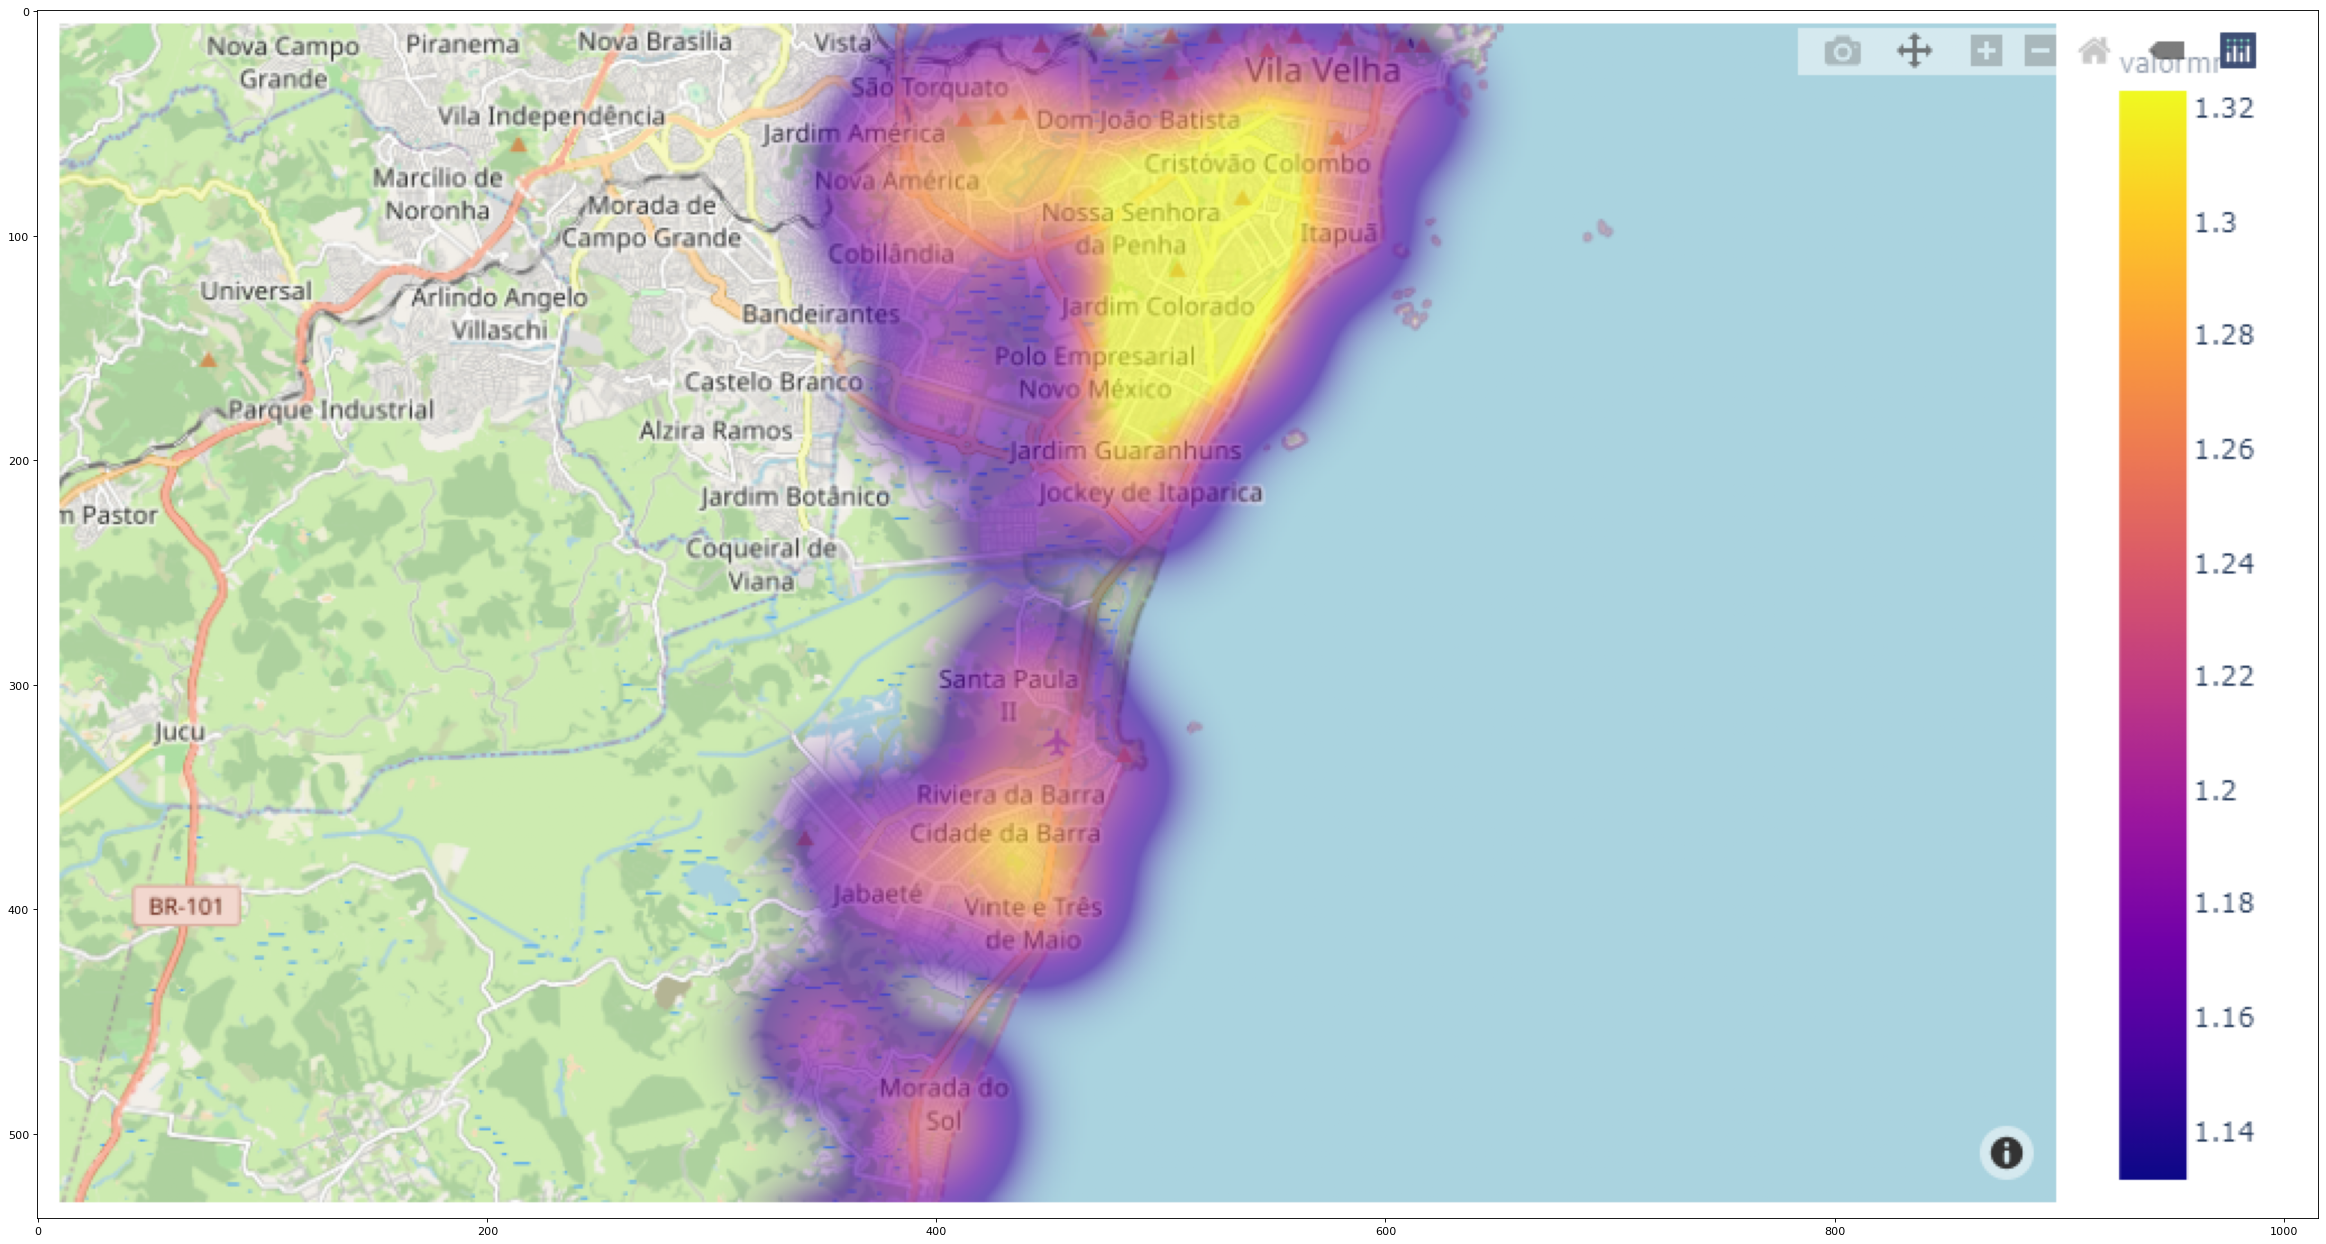

In [30]:
# Obs.: O mapa aparentemente não pode ser mostrado no github então o exibirei como imagem, mas ele é interativo :/

import matplotlib.image as mpimg
from matplotlib.pyplot import figure
figure(num=None, figsize=(50, 20), dpi=80, facecolor='w', edgecolor='k')
image = mpimg.imread("file.png")
plt.imshow(image)
plt.show()

### Conclusão:
#### Os dados podem não ser muito fiéis, mas representaram em parte o que eu esperava. Os bairros mais próximos aos centros de comércios ou praia costumam ter um valor relativo maior que os demais, como pode ser observado no mapa.